<a href="https://colab.research.google.com/github/hemant-chapa23/ActivityDetector/blob/main/DL_Assignment_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 i. Import Libraries/Dataset (0 mark)

  * Import the required libraries.
  * Check the GPU available (recommended- use free GPU provided by Google Colab)

ii. Data Processing(1 mark)

 * Convert the data into the correct format which could be used for the DL model.
 * Plot at least two samples and their captions (use matplotlib/seaborn/any other library).
 * Load the data into train and test data in the required format.


iii. Model Building (4 mark)

 * Use any pre-trained model trained on ImageNet dataset (available publicly on Google) for image feature extraction.
 * Create k-layered LSTM model and other relevant layers.
 * Add one layer of dropout at the appropriate position and give reasons.
 * Choose the appropriate activation function for all the layers.
 * Print the model summary.
 * Justify the choice of number of layers, activation function and any other hyper parameters used.

iv. Model Compilation (2 mark)

 * Compile the model with the appropriate loss function.
 * Use an appropriate optimizer.
 * Justify the choice of learning rate, optimizer, loss function and any other hyper parameter used.


v. Model Training (2 mark)

* Train the model for an appropriate number of epochs.
* Print the train and validation loss for each epoch. Use the appropriate batch size.
* Plot the loss and accuracy history graphs for both train and validation set.
* Print the total time taken for training.


vi. Model Evaluation (1 mark)

* Take 5 random data from the test set and perform activity recognition.
* Print confusion metrics and classification report for the test data.

In [2]:
import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

import os
import re
import time
import json

import string
from collections import Counter

import pickle
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  
nltk.download('punkt')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import os
path_name = "/content/drive/MyDrive/UCF-101/Dataset/train"

In [4]:
filenames = os.listdir(path_name)
print(len(filenames))
filenames = [v.split('_')[1] for v in filenames]
Counter(filenames)

6389


Counter({'BaseballPitch': 1500,
         'BandMarching': 1569,
         'Basketball': 1340,
         'BabyCrawling': 970,
         'ApplyEyeMakeup': 1010})

In [5]:
# os.listdir(path_name)

In [6]:
image_model   = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
image_input   = image_model.input
feature_layer = image_model.layers[-1].output

image_feature_extraction = tf.keras.Model(image_input, feature_layer)
image_feature_extraction.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [7]:
def decode_and_resize(img_path):
    
    ###### Read image from the path mentioned 
    img = tf.io.read_file(img_path)
    
    ####### Decode a JPEG-encoded image to a uint8 tensor. The channels=3 parameter will ensure we output RGB image. 
    img = tf.image.decode_jpeg(img, channels=3)
    
    ###### We resize the image to size 300x300 to make it consistent accross all images which will make it easy to train 
    img = tf.image.resize(img, (300,300))
    
    ##### We convert the image to float32 which will be our final image tensor that goes in the model.
    
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img,img_path

In [8]:
train_path = os.listdir(path_name)
train_path = ["/content/drive/MyDrive/UCF-101/Dataset/train/"+v for v in train_path]
print(len(train_path))

6389


In [8]:
test_path = os.listdir(path_name)
test_path = ["/content/drive/MyDrive/UCF-101/Dataset/test/"+v for v in test_path]
print(len(test_path))

In [9]:
labels = {'BandMarching':0,'ApplyEyeMakeup':1,'Basketball':2,'BaseballPitch':3,'BabyCrawling':4}

In [10]:
y_train = os.listdir(path_name)
y_train = [val for val in y_train if '.npy' not in val]
y_train = [v.split('_')[1] for v in y_train]
y_train = [labels[v] for v in filenames]
y_train = np.array(y_train)

In [ ]:
y_test = os.listdir(path_name)
y_test = [val for val in y_test if '.npy' not in val]
y_test = [v.split('_')[1] for v in y_test]
y_test = [labels[v] for v in filenames]
y_test = np.array(y_train)

In [11]:
y_train.shape

(6389,)

In [12]:
encode        = sorted(set(train_path))
image_dataset = tf.data.Dataset.from_tensor_slices(encode)
image_dataset = image_dataset.map(decode_and_resize, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)

preprocessed_features = []

for img,path in tqdm(image_dataset):
    batch_features = image_feature_extraction(img)[0][1][1]
    batch_features = tf.reshape(batch_features, [2048])
    preprocessed_features.append(batch_features.numpy())


  0%|          | 0/6389 [00:00<?, ?it/s]

In [13]:
# y_train = y_train[:2421]

In [14]:
# np.array(preprocessed_features).shape,y_train.shape

In [15]:
X_train = np.array(preprocessed_features)

In [16]:
# set(y_train)

In [17]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y_train = ohe.fit_transform(y_train.reshape(-1,1))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [19]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state= 1)

In [20]:
num_classes = 5

def define_model(lstm_nodes,nodes ):
  model = Sequential([
  LSTM(lstm_nodes, input_shape=(2048, 1), activation='tanh'),
  Dense(nodes, activation='relu'),
  Dense(num_classes, activation='softmax')  
  ])
  return model

# Train the model
def train_model(model):
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  history = model.fit(x_tr.reshape((x_tr.shape[0], x_tr.shape[1], 1)), y_tr, validation_data = (x_val, y_val), batch_size=32,epochs=50,verbose = 0)
  return history

def plot_results(history):
  plt.figure(figsize=(10,8))
  plt.title(f"Accuracy vs Epochs - {lstm_nodes} LSTM nodes and {nodes} Dense Layer nodes")
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Test Accuracy')
  plt.legend(loc='best')
  plt.yticks = np.arange(0,1.1, 0.1)
  plt.show()


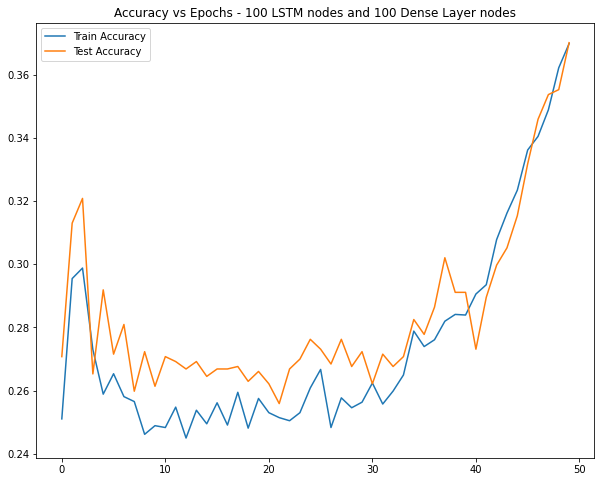

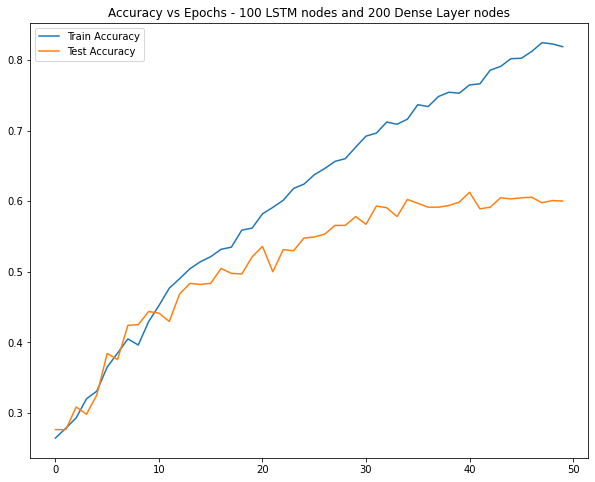

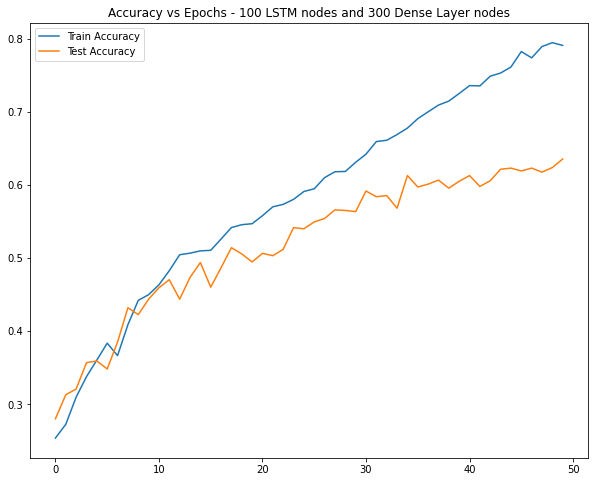

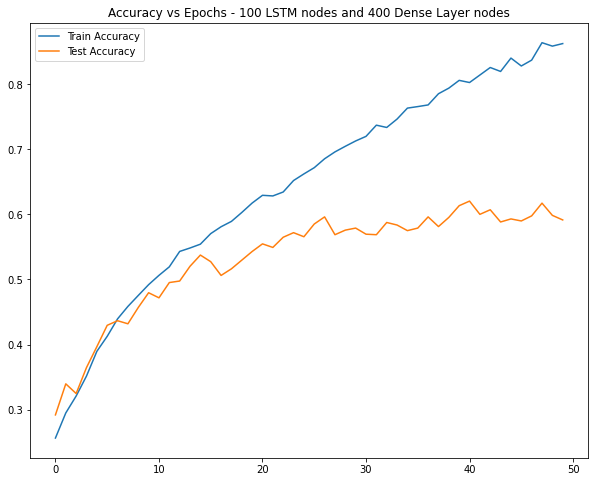

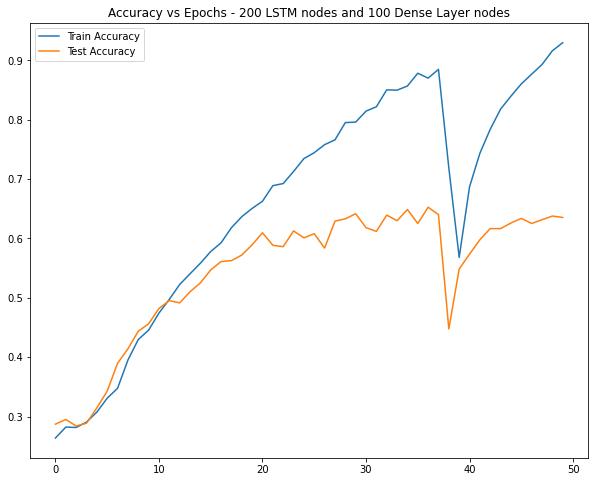

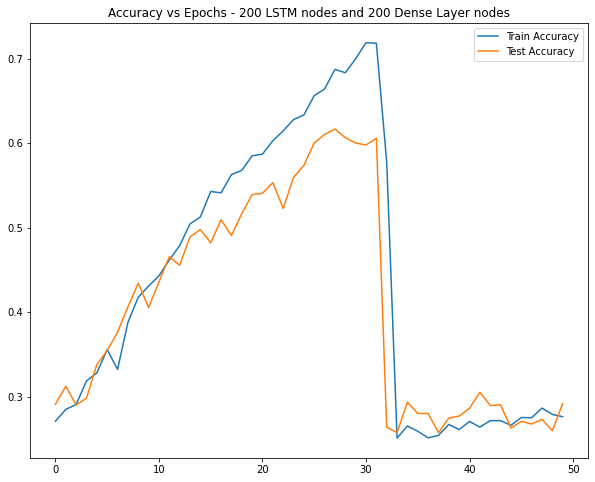

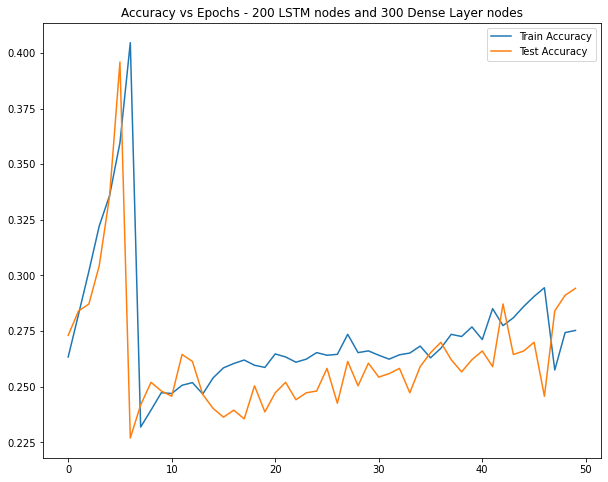

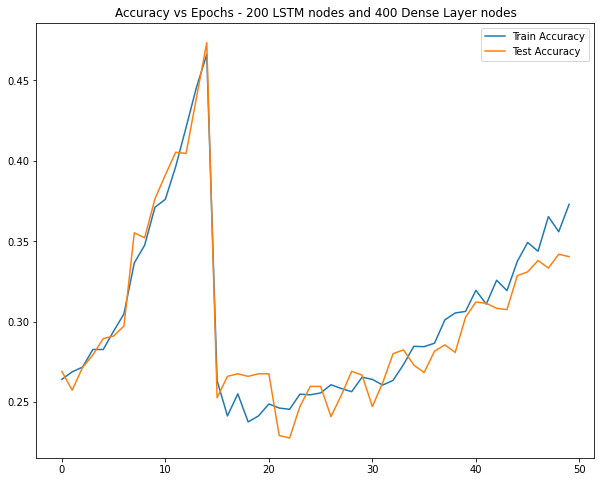

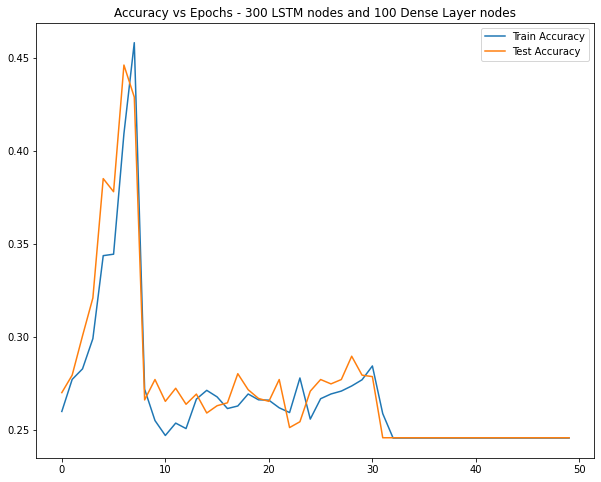

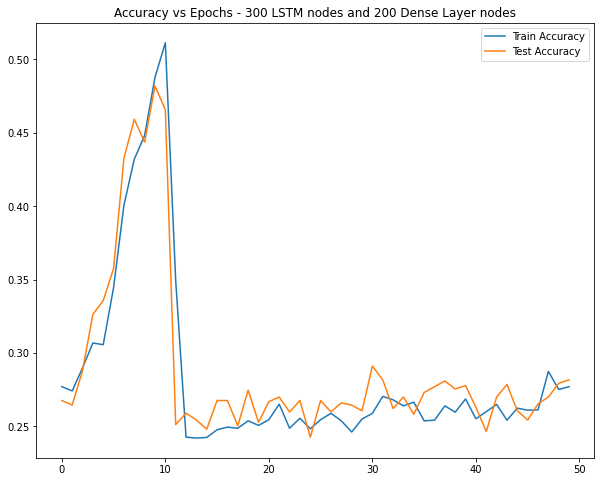

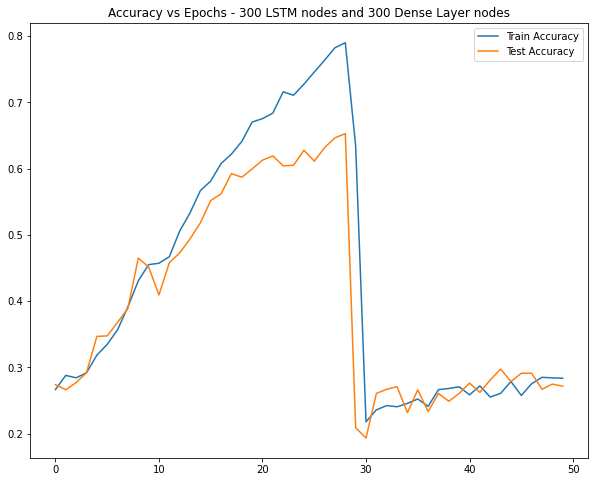

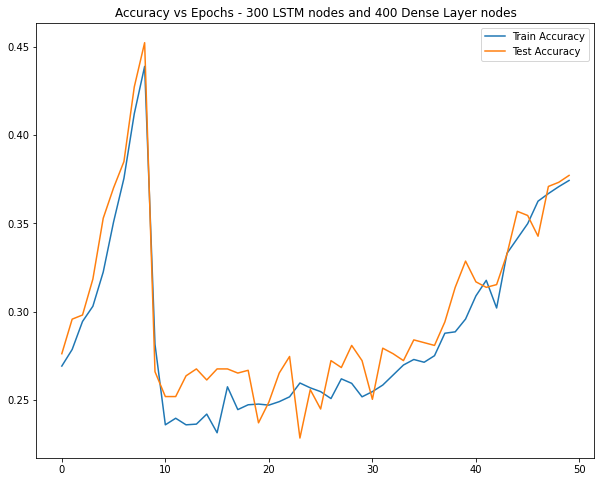

In [ ]:
for lstm_nodes in range(100,500, 100):
  for nodes in range(100,500, 100):
    model_ = define_model(lstm_nodes,nodes)
    history = train_model(model_)
    plot_results(history)

From the above graphs, it can be observed that the best parameters for the number of the LSTM nodes and the Dense layer nodes are 100 and 300 respectively.

In [ ]:
final_model = define_model(100,300)
final_history = train_model(final_model)

array([0., 1.])

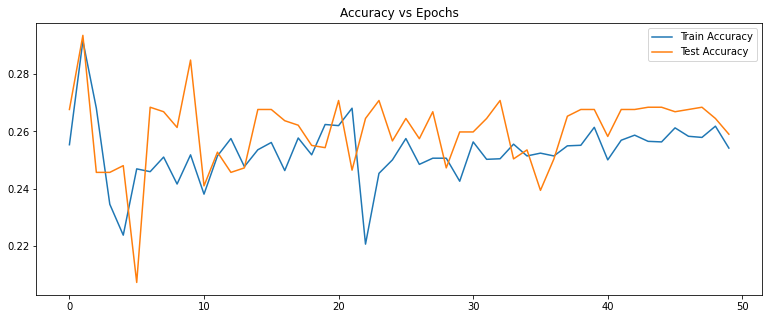

In [ ]:
final_history.predict()

In [ ]:
model.history['accuracy']

TypeError: ignored

In [ ]:
#TODO:
#Train the model with different LSTM layers
#Use Dropout
#TAccuracy Plotting for each Epoch